In [1]:
input_sdate = "2023 08 20"
input_edate = "2023 08 25"
bbox = [112.70505, -44.52755, 154.38241, -11.29524]


In [2]:

%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc4
import xarray as xr
import fsspec
import numpy as np
import xarray as xr
import planetary_computer
import pystac_client
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime, time


In [3]:
# Initialize PySTAC client for data query
planetary_computer.set_subscription_key("c27669c4bdec434d804e2bd738cb16fc")
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
# Function to convert date format 
def convert_format_date(input_date):
    date_obj = datetime.strptime(input_date, "%Y %m %d")
    formatted_date = date_obj.strftime("%Y-%m-%d")
    return formatted_date

# Convert user start date format
input_sdate = convert_format_date(input_sdate)

# Convert user end date format
input_edate = convert_format_date(input_edate)

date_period = input_sdate + "/" + input_edate 
date_period

'2023-08-20/2023-08-25'

In [5]:
search = catalog.search(
    collections="sentinel-5p-l2-netcdf",
    bbox = bbox,
    datetime=input_sdate + "/" + input_edate,
    query={"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "ch4"}},
)
items = search.item_collection()

print(len(items))

20


In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # Get geopandas in-built naturalearth_lowres dataset
print(world)

         pop_est      continent                      name iso_a3  gdp_md_est  \
0       889953.0        Oceania                      Fiji    FJI        5496   
1     58005463.0         Africa                  Tanzania    TZA       63177   
2       603253.0         Africa                 W. Sahara    ESH         907   
3     37589262.0  North America                    Canada    CAN     1736425   
4    328239523.0  North America  United States of America    USA    21433226   
..           ...            ...                       ...    ...         ...   
172    6944975.0         Europe                    Serbia    SRB       51475   
173     622137.0         Europe                Montenegro    MNE        5542   
174    1794248.0         Europe                    Kosovo    -99        7926   
175    1394973.0  North America       Trinidad and Tobago    TTO       24269   
176   11062113.0         Africa                  S. Sudan    SSD       11998   

                                       

/tmp/ipykernel_1217/2597108426.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # Get geopandas in-built naturalearth_lowres dataset


/tmp/ipykernel_1217/2633512526.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # Get geopandas in-built naturalearth_lowres dataset


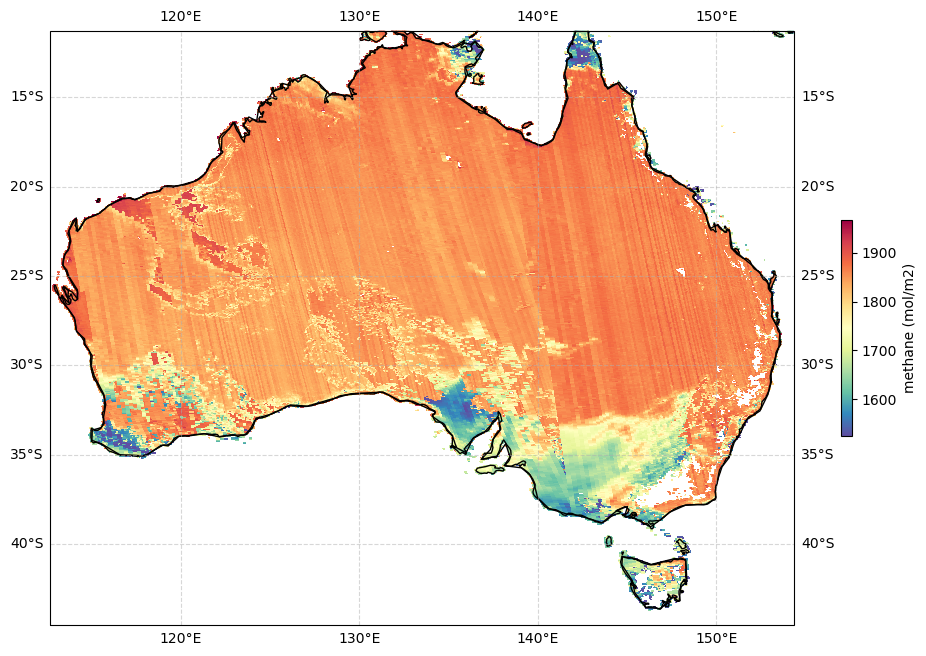

In [7]:


# Initialize the map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # Get geopandas in-built naturalearth_lowres dataset

fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
continent_borders = world.dissolve(by='continent')
continent_borders.boundary.plot(ax=ax, linewidth=1, color='black')
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle="--")
#ax.set_extent(geometry, crs=ccrs.PlateCarree())

# Loop through each item
for item in items:
    # Open the file
    with fsspec.open(item.assets['ch4'].href).open() as f:
        ds = xr.open_dataset(f, group="PRODUCT", engine="h5netcdf")
        
        # Extract the relevant data (assuming the variable name is 'methane_mixing_ratio_bias_corrected')
        data = ds['methane_mixing_ratio_bias_corrected'][0, :, :]
        #print(data.values)
        lon = ds['longitude'].values.squeeze()
        lat = ds['latitude'].values.squeeze()
        
        # Calculate vmin and vmax for color normalization
        vmin, vmax = np.nanpercentile(data, [1, 99])
        
        #Plot the data
   
        cmap = cm.Spectral.reversed()
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        colormesh = ax.pcolormesh(lon, lat, data.values, cmap= cmap, norm=norm, transform=ccrs.PlateCarree())


fig.colorbar(colormesh, pad=0.05, shrink=0.35, label="methane (mol/m2)")
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

plt.show()